In [1]:
import numerapi
import os
from dotenv import load_dotenv
import pandas as pd
import yfinance


import simplejson

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests as re
import datetime

load_dotenv() 



True

In [2]:
df_train = pd.read_parquet(
    f"signals/v1.0/train.parquet"
)

df_validation = pd.read_parquet(
    f"signals/v1.0/validation.parquet"
)

ticket = list(set(df_train["numerai_ticker"]))

In [3]:
df_final=pd.concat([df_train,df_validation])
df_final

,numerai_ticker,composite_figi,date,data_type,feature_impact_cost_factor,feature_beta_factor,feature_volatility_factor,feature_momentum_12w_factor,feature_momentum_26w_factor,feature_momentum_52w_factor,...,target_irina_60,target_alexandra_20,target_alexandra_60,target_colleen_20,target_colleen_60,target_jean_20,target_jean_60,target_eleven_4,target_eleven_20,target_eleven_60
0,000270 KR,None,2003-01-03,train,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.00,0.25,0.25
1,000810 KR,None,2003-01-03,train,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25,0.50,0.25,0.50,0.25,0.50,0.25,0.50,0.25,0.25
2,002790 KR,None,2003-01-03,train,NaN,NaN,NaN,NaN,NaN,NaN,...,0.50,0.50,0.25,0.50,0.25,0.50,0.25,0.25,0.50,0.25
3,003490 KR,None,2003-01-03,train,NaN,NaN,NaN,NaN,NaN,NaN,...,0.50,0.75,0.25,1.00,0.25,1.00,0.25,1.00,0.50,0.50
4,003600 KR,None,2003-01-03,train,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.50,0.00,0.50,0.00,0.50,0.00,0.75,0.50,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043436,ZV IT,BBG000BXQXG6,2024-08-09,test,0.513639,-0.108599,-0.456008,-0.167282,-0.382000,-0.944364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3043437,ZVRA US,BBG0026ZG1F5,2024-08-09,test,0.476946,-0.282401,1.357650,2.084780,0.296189,0.721885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3043438,ZWS US,BBG000H8R0N8,2024-08-09,test,-1.137027,0.526970,-1.025734,-0.267946,-0.321092,0.031295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3043439,ZYME US,BBG019XSYC89,2024-08-09,test,0.116176,0.498045,0.502151,1.026341,-0.503710,1.053135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def plot_ticker_counts_per_date(df, title, color_column):
    df['date'] = pd.to_datetime(df['date'])
    
    # Count unique 'numerai_ticker' per 'date'
    nticker_count_per_date = df.groupby('date')['numerai_ticker'].nunique().reset_index(name='numerai_ticker_count')

    # Check if color_column exists in the DataFrame
    if color_column not in df.columns:
        raise ValueError(f"Column '{color_column}' not found in the DataFrame")

    # Map categorical values to colors
    unique_categories = df[color_column].unique()
    color_map = {cat: plt.cm.tab10(i / len(unique_categories)) for i, cat in enumerate(unique_categories)}
    
    # Add colors to the DataFrame
    df['color'] = df[color_column].map(color_map)
    
    # Merge colors into the counts DataFrame
    color_map_per_date = df.drop_duplicates(subset=['date', color_column]).set_index('date')['color'].to_dict()
    nticker_count_per_date['color'] = nticker_count_per_date['date'].map(color_map_per_date)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.scatter(nticker_count_per_date['date'], nticker_count_per_date['numerai_ticker_count'], 
                c=nticker_count_per_date['color'], edgecolor='k', marker='o')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=cat, 
                          markersize=10, markerfacecolor=color_map[cat]) 
               for cat in unique_categories]
    plt.legend(handles=handles, title=color_column)
    
    plt.tight_layout()
    plt.show()




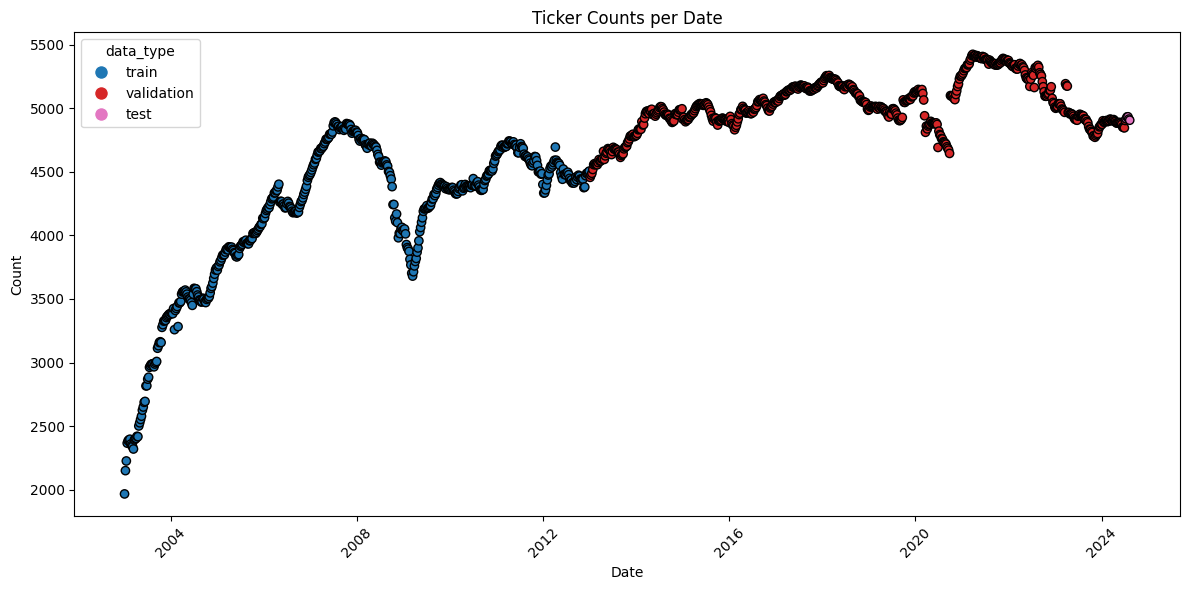

In [5]:
plot_ticker_counts_per_date(df_final, 'Ticker Counts per Date', 'data_type')

In [6]:
#eligible_tickers = pd.Series(napi.ticker_universe(), name='ticker') 

eligible_tickers = pd.Series(list(set(df_final["numerai_ticker"])), name='ticker') 
print(f"Number of eligible tickers: {len(eligible_tickers)}")



Number of eligible tickers: 14956


In [7]:
list_us=[x for x in eligible_tickers if "GOOGL" in x]
list_us




['GOOGL US']

In [8]:
def extraer_ticket_yahoo(x):
    x=x.split(" ")[0]
    return x

In [9]:
df_final["prueba"]=df_final["numerai_ticker"].apply(extraer_ticket_yahoo)

In [10]:
eligible_tickers = pd.Series(list(set(df_final["prueba"])), name='ticker') 
print(f"Number of eligible tickers: {len(eligible_tickers)}")

Number of eligible tickers: 13413


In [11]:
n = 600  #chunk row size
chunk_df = [eligible_tickers.iloc[i:i+n] for i in range(0, len(eligible_tickers), n)]

start_date = datetime.datetime.now() - datetime.timedelta(days=365*25)
concat_dfs = []
h = 1
for df in chunk_df:

    print(f"Se esta extrayendo el bloque {h}")

    h= h+1

    try:
        # set threads = True for faster performance, but tickers will fail, scipt may hang
        # set threads = False for slower performance, but more tickers will succeed
        temp_df = yfinance.download(df.str.cat(sep=' '), start=start_date, threads=False)
        temp_df = temp_df['Adj Close'].stack().reset_index()
        concat_dfs.append(temp_df)
    except simplejson.errors.JSONDecodeError:
        pass



Se esta extrayendo el bloque 1


[                       0%%                      ]  3 of 600 completed

$HLSS: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*                      2%%                      ]  9 of 600 completed

$JGW: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*                      3%%                      ]  20 of 600 completed

$KNOT: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[**                     4%%                      ]  24 of 600 completed

$SHRP: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[**                     5%%                      ]  31 of 600 completed

$BNI: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[***                    7%%                      ]  41 of 600 completed

$NNB: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)
$BEAV: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*****                 11%%                      ]  64 of 600 completed

$SQNM: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)
$ASYT: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*****                 11%%                      ]  66 of 600 completed

$TVIA: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[******                12%%                      ]  69 of 600 completed

$AMRI: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[******                12%%                      ]  71 of 600 completed

$RHA: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[******                12%%                      ]  72 of 600 completedFailed to get ticker 'DY/' reason: Expecting value: line 1 column 1 (char 0)
[*******               14%%                      ]  81 of 600 completed

$ROOM: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)
$MDVN: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*******               14%%                      ]  86 of 600 completed

$CMOS: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[********              16%%                      ]  93 of 600 completed

$JRN: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[********              17%%                      ]  104 of 600 completed

$XNPT: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*********             18%%                      ]  111 of 600 completed

$NSPH: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*********             19%%                      ]  114 of 600 completed

$GFIG: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[**********            21%%                      ]  126 of 600 completedFailed to get ticker 'BCE/' reason: Expecting value: line 1 column 1 (char 0)
[***********           22%%                      ]  133 of 600 completedFailed to get ticker 'BPY/UN' reason: Expecting value: line 1 column 1 (char 0)
[***********           23%%                      ]  136 of 600 completedFailed to get ticker 'OGC/' reason: Expecting value: line 1 column 1 (char 0)
[************          24%%                      ]  146 of 600 completed

$CIMA: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*************         28%%                      ]  165 of 600 completedFailed to get ticker 'RCI/B' reason: Expecting value: line 1 column 1 (char 0)
[**************        29%%                      ]  176 of 600 completed

$HU: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)
$FTFC: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[***************       32%%                      ]  190 of 600 completed

$DSCO: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*****************     35%%                      ]  209 of 600 completedFailed to get ticker 'PPL/' reason: Expecting value: line 1 column 1 (char 0)
[*****************     36%%                      ]  213 of 600 completed

$TNGO: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*****************     36%%                      ]  215 of 600 completed

$HUVL: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[******************    37%%                      ]  224 of 600 completedFailed to get ticker 'WDO/' reason: Expecting value: line 1 column 1 (char 0)
[******************    38%%                      ]  226 of 600 completed

$CURY: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*******************   40%%                      ]  238 of 600 completed

$KKD: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[*******************   40%%                      ]  241 of 600 completed

$EICU: possibly delisted; No price data found  (1d 1999-08-29 19:46:53.522083 -> 2024-08-22)


[********************  42%%                      ]  249 of 600 completed

In [34]:
full_data = pd.concat(concat_dfs)
full_data.columns = ['date', 'ticker', 'price']


In [35]:
full_data

,date,ticker,price
0,1999-08-30,APT,1.000000
1,1999-08-30,AVNW,81.375000
2,1999-08-30,AVT,17.650112
3,1999-08-30,AZN,7.935712
4,1999-08-30,BMRN,15.875000
...,...,...,...
241808,2024-08-21,TRAK,18.170000
241809,2024-08-21,TWIN,12.710000
241810,2024-08-21,VRN,7.265000
241811,2024-08-21,ZD,45.660000


In [36]:
#full_data.columns = ['date', 'ticker', 'price']
full_data.set_index('date', inplace=True)

# convert yahoo finance tickers back to numerai tickers
# full_data['ticker'] = full_data.ticker.map(dict(zip(eligible_tickers, numerai_tickers)))

print(f"Number of tickers with data: {len(full_data.ticker.unique())}")
full_data.head()

Number of tickers with data: 4745


,ticker,price
date,,
1999-08-30,APT,1.000000
1999-08-30,AVNW,81.375000
1999-08-30,AVT,17.650112
1999-08-30,AZN,7.935712
1999-08-30,BMRN,15.875000


In [37]:
def RSI(prices, interval=14):
  '''Computes Relative Strength Index given a price series and lookback interval
  Modified from https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
  See more here https://www.investopedia.com/terms/r/rsi.asp'''
  delta = prices.diff()

  dUp, dDown = delta.copy(), delta.copy()
  dUp[dUp < 0] = 0
  dDown[dDown > 0] = 0

  RolUp = dUp.rolling(interval).mean()
  RolDown = dDown.rolling(interval).mean().abs()

  RS = RolUp / RolDown
  RSI = 100.0 - (100.0 / (1.0 + RS))
  return RSI

In [38]:
ticker_groups = full_data.groupby('ticker')
full_data['RSI'] = ticker_groups['price'].transform(lambda x: RSI(x))

In [39]:
date_groups = full_data.groupby(full_data.index)
date_groups['RSI']

In [40]:
for date, group in date_groups:
    print(f"Date: {date}")
    print(group['RSI'])
    print("------")

Date: 1999-08-30 00:00:00
date
1999-08-30   NaN
1999-08-30   NaN
1999-08-30   NaN
1999-08-30   NaN
1999-08-30   NaN
              ..
1999-08-30   NaN
1999-08-30   NaN
1999-08-30   NaN
1999-08-30   NaN
1999-08-30   NaN
Name: RSI, Length: 1433, dtype: float64
------
Date: 1999-08-31 00:00:00
date
1999-08-31   NaN
1999-08-31   NaN
1999-08-31   NaN
1999-08-31   NaN
1999-08-31   NaN
              ..
1999-08-31   NaN
1999-08-31   NaN
1999-08-31   NaN
1999-08-31   NaN
1999-08-31   NaN
Name: RSI, Length: 1432, dtype: float64
------
Date: 1999-09-01 00:00:00
date
1999-09-01   NaN
1999-09-01   NaN
1999-09-01   NaN
1999-09-01   NaN
1999-09-01   NaN
              ..
1999-09-01   NaN
1999-09-01   NaN
1999-09-01   NaN
1999-09-01   NaN
1999-09-01   NaN
Name: RSI, Length: 1434, dtype: float64
------
Date: 1999-09-02 00:00:00
date
1999-09-02   NaN
1999-09-02   NaN
1999-09-02   NaN
1999-09-02   NaN
1999-09-02   NaN
              ..
1999-09-02   NaN
1999-09-02   NaN
1999-09-02   NaN
1999-09-02   NaN
1999

In [42]:
date_groups = full_data.groupby(full_data.index)
full_data.dropna(inplace=True)

full_data['RSI_quintile'] = date_groups['RSI'].transform(lambda group: pd.qcut(group, 5, labels=False, duplicates='drop'))

full_data.head()

IndexError: index 16409362 is out of bounds for axis 0 with size 16347048

In [ ]:
ticker_groups = full_data.groupby('ticker')

#create lagged features, lag 0 is that day's value, lag 1 is yesterday's value, etc
num_days = 5
for day in range(num_days+1):
    full_data[f'RSI_quintile_lag_{day}'] = ticker_groups['RSI_quintile'].transform(lambda group: group.shift(day))

In [ ]:
full_data.tail()

,ticker,price,RSI,RSI_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5
date,,,,,,,,,,
2024-08-20,ZS US,198.750000,68.923127,4,4,4.0,4.0,4.0,3.0,2.0
2024-08-20,ZUMZ US,27.264999,62.341138,4,4,4.0,4.0,4.0,4.0,4.0
2024-08-20,ZUO US,8.720000,40.641726,1,1,2.0,1.0,0.0,1.0,1.0
2024-08-20,ZVRA US,7.500000,60.369614,4,4,4.0,4.0,4.0,4.0,3.0
2024-08-20,ZYME US,10.650000,53.696492,3,3,3.0,2.0,2.0,2.0,3.0


In [58]:
for day in range(num_days):
    full_data[f'RSI_diff_{day}'] = full_data[f'RSI_quintile_lag_{day}'] - full_data[f'RSI_quintile_lag_{day + 1}']
    full_data[f'RSI_abs_diff_{day}'] = np.abs(full_data[f'RSI_quintile_lag_{day}'] - full_data[f'RSI_quintile_lag_{day + 1}'])

In [59]:
full_data.tail()

,ticker,price,RSI,RSI_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,
2024-08-20,ZS US,198.750000,68.923127,4,4,4.0,4.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2024-08-20,ZUMZ US,27.264999,62.341138,4,4,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-20,ZUO US,8.720000,40.641726,1,1,2.0,1.0,0.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,0.0,0.0
2024-08-20,ZVRA US,7.500000,60.369614,4,4,4.0,4.0,4.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2024-08-20,ZYME US,10.650000,53.696492,3,3,3.0,2.0,2.0,2.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0


In [60]:
feature_names = [f'RSI_quintile_lag_{num}' for num in range(num_days)] + [f'RSI_diff_{num}' for num in range(num_days)] + [f'RSI_abs_diff_{num}' for num in range(num_days)]
print(f'Features for training:\n {feature_names}')

Features for training:
 ['RSI_quintile_lag_0', 'RSI_quintile_lag_1', 'RSI_quintile_lag_2', 'RSI_quintile_lag_3', 'RSI_quintile_lag_4', 'RSI_diff_0', 'RSI_diff_1', 'RSI_diff_2', 'RSI_diff_3', 'RSI_diff_4', 'RSI_abs_diff_0', 'RSI_abs_diff_1', 'RSI_abs_diff_2', 'RSI_abs_diff_3', 'RSI_abs_diff_4']


In [75]:
df_train = df_train.rename(columns={'numerai_ticker': 'ticker'})

df_train["date"] = pd.to_datetime(df_train["date"])

In [84]:
ML_data = pd.merge(df_train, full_data.reset_index(), on=['date','ticker'], how="left").set_index('date')

In [98]:
filtrado=ML_data[(ML_data["price"].isna()) & (ML_data["ticker"]=="MSFT US")]

In [105]:
from scipy.stats.mstats import winsorize

In [112]:
def winsorized_mean(series, limits=(0.05, 0.05)):
    if series.dropna().empty:
        return float('nan')  # O un valor predeterminado apropiado
    winsorized_series = winsorize(series.dropna(), limits=limits)
    return pd.Series(winsorized_series).mean()

# Aplicar winsorization para cada ticker
def calculate_winsorized_means(group):
    return winsorized_mean(group['price'], limits=(0.05, 0.05))

In [117]:
winsorized_means = ML_data.groupby('ticker').apply(calculate_winsorized_means)

In [118]:
winsorized_means.reset_index()

,ticker,0
0,000060 KR,NaN
1,000070 KR,NaN
2,000080 KR,NaN
3,000100 KR,NaN
4,000120 KR,NaN
...,...,...
9616,ZRG ES,NaN
9617,ZUMZ US,23.8465
9618,ZURN CH,NaN
9619,ZVO US,NaN
